In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import Planetoid

# Load the dataset
dataset = Planetoid(root='data/Cora', name='Cora')

# Extract the graph
data = dataset[0]

Processing...
Done!


In [ ]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Train nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")


Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7
Train nodes: 140
Validation nodes: 500
Test nodes: 1000


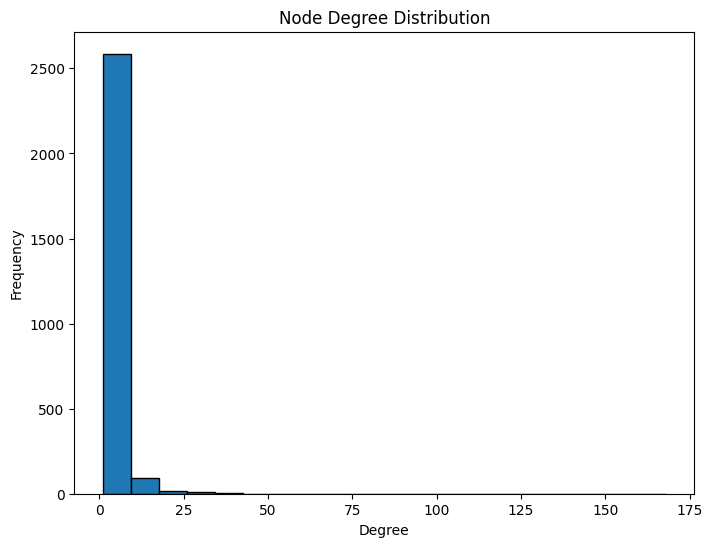

In [ ]:
import matplotlib.pyplot as plt

from torch_geometric.utils import degree

# Compute degrees
degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(degrees.numpy(), bins=20, edgecolor="black")
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


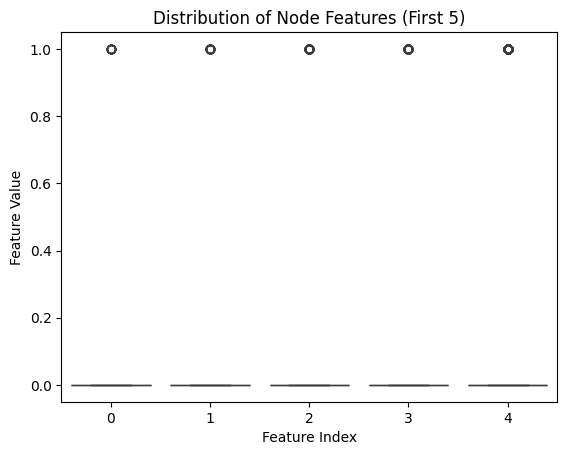

In [ ]:
import seaborn as sns
import pandas as pd

# Convert features to a Pandas DataFrame for analysis
features_df = pd.DataFrame(data.x.numpy())

# Visualize feature distribution for a few features
sns.boxplot(data=features_df.iloc[:, :5])
plt.title("Distribution of Node Features (First 5)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()


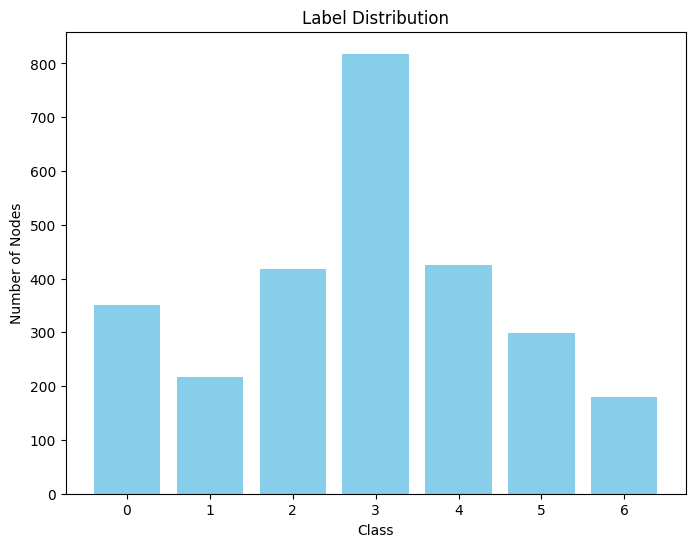

In [ ]:
import numpy as np

labels = data.y.numpy()
unique, counts = np.unique(labels, return_counts=True)

# Plot label distribution
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, color='skyblue')
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Nodes")
plt.show()


In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Plot the graph with node labels as colors
plt.figure(figsize=(12, 12))
nx.draw(G, node_color=labels, cmap=plt.cm.tab10, node_size=50, with_labels=False)
plt.title("Cora Graph Visualization")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Hyperparameters
hidden_channels = 16
model = GCN(dataset.num_node_features, hidden_channels, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Move data to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store metrics
train_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(200):
    # Training phase
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())  # Log training loss

    # Evaluation phase
    model.eval()
    _, pred = model(data).max(dim=1)  # Get predictions
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = test_correct / data.test_mask.sum().item()
    test_accuracies.append(acc)  # Log test accuracy

    # Compute precision, recall, and F1-score for the test set
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Epoch 0, Loss: 0.0107, Test Acc: 0.8060, Precision: 0.7844, Recall: 0.8192, F1: 0.7981
Epoch 1, Loss: 0.0106, Test Acc: 0.8060, Precision: 0.7844, Recall: 0.8192, F1: 0.7981
Epoch 2, Loss: 0.0106, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 3, Loss: 0.0106, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 4, Loss: 0.0105, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 5, Loss: 0.0105, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 6, Loss: 0.0105, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 7, Loss: 0.0105, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 8, Loss: 0.0104, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 9, Loss: 0.0104, Test Acc: 0.8050, Precision: 0.7832, Recall: 0.8182, F1: 0.7969
Epoch 10, Loss: 0.0104, Test Acc: 0.8070, Precision: 0.7850, Recall: 0.8191, F1: 0.7984
Epoch 11, Loss: 0.0103, Test Acc: 0.8070, 

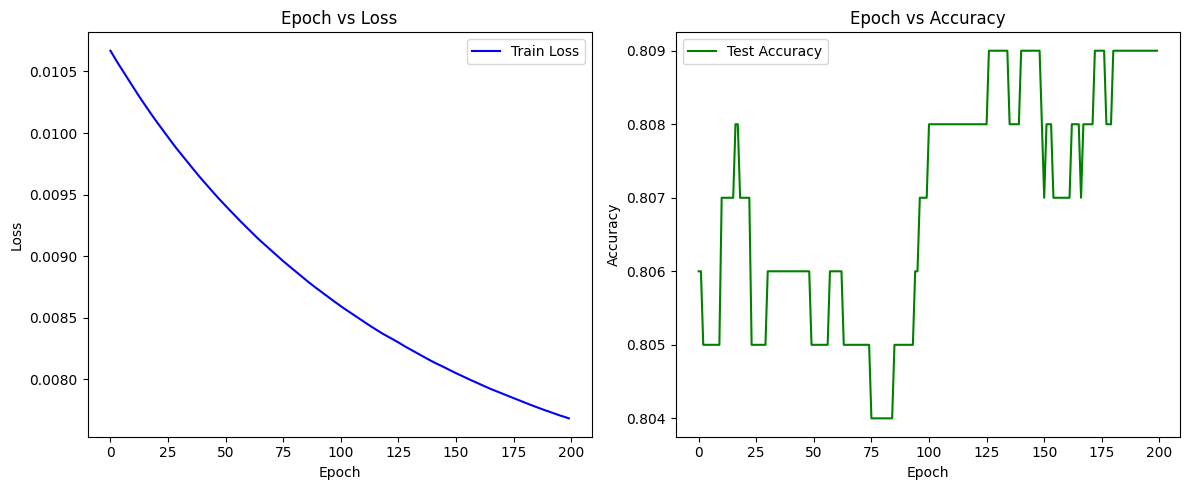

In [ ]:
import matplotlib.pyplot as plt

# Plot Epoch vs Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(200), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plot Epoch vs Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(200), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

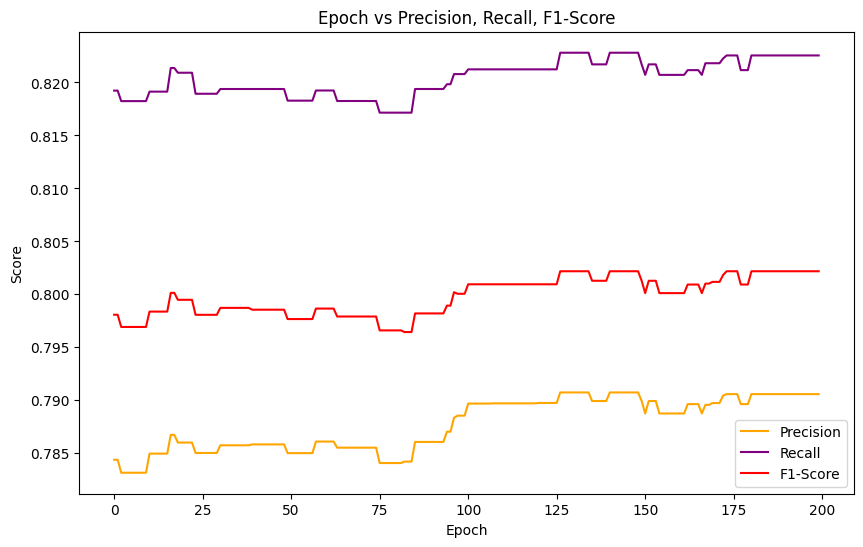

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(200), precisions, label='Precision', color='orange')
plt.plot(range(200), recalls, label='Recall', color='purple')
plt.plot(range(200), f1_scores, label='F1-Score', color='red')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Epoch vs Precision, Recall, F1-Score')
plt.legend()
plt.show()

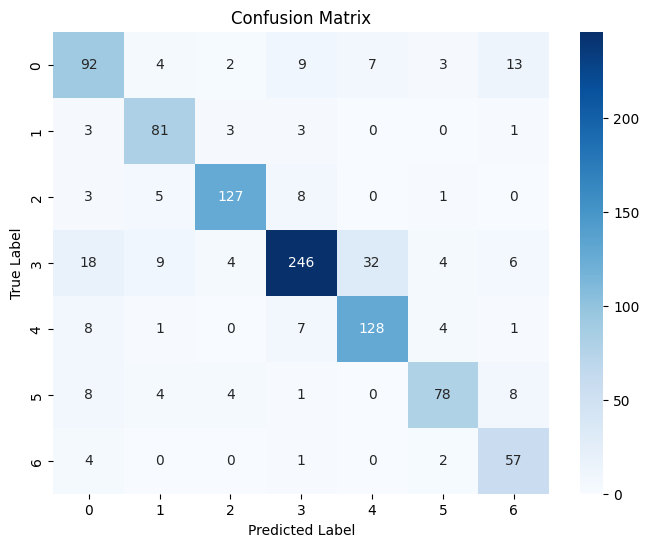


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       130
           1       0.78      0.89      0.83        91
           2       0.91      0.88      0.89       144
           3       0.89      0.77      0.83       319
           4       0.77      0.86      0.81       149
           5       0.85      0.76      0.80       103
           6       0.66      0.89      0.76        64

    accuracy                           0.81      1000
   macro avg       0.79      0.82      0.80      1000
weighted avg       0.82      0.81      0.81      1000


Balanced Accuracy: 0.8226
ROC-AUC Score: 0.9663
Log Loss: 0.6171


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    roc_auc_score,
    log_loss,
    roc_curve,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Switch to evaluation mode
model.eval()
_, pred = model(data).max(dim=1)  # Get predictions

# Extract test labels and predictions
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_true),
    yticklabels=np.unique(y_true),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")

# ROC-AUC (One-vs-Rest)
if len(np.unique(y_true)) > 2:  # Multiclass case
    y_proba = model(data).softmax(dim=1)[data.test_mask].cpu().detach().numpy()
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
else:  # Binary case
    y_proba = model(data).softmax(dim=1)[:, 1][data.test_mask].cpu().detach().numpy()
    roc_auc = roc_auc_score(y_true, y_proba)

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Log Loss
logloss = log_loss(y_true, y_proba)
print(f"Log Loss: {logloss:.4f}")

In [ ]:
import torch
# Save the model
torch.save(model.state_dict(), "model_cora_state.pth")
print("Model state dictionary saved.")

Model state dictionary saved.


In [ ]:
!pip install streamlit torch-geometric networkx matplotlib plotly pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import pandas as pd
import plotly.express as px
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize model with appropriate dimensions
hidden_channels = 16
model = GCN(dataset.num_node_features, hidden_channels, dataset.num_classes)

# Load the saved state dictionary
model.load_state_dict(torch.load("model_cora_state.pth"))
model.eval()
print("Model state dictionary loaded.")

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Use a layout for node positions
pos = nx.spring_layout(G)  # Positions for nodes
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]

# Get predicted classes (assuming predictions are already computed)
_, pred = model(data).max(dim=1)
predicted_classes = pred.cpu().numpy()

# Create a DataFrame for nodes
node_data = pd.DataFrame({
    'x': x_nodes,
    'y': y_nodes,
    'class': predicted_classes
})

# Streamlit App
st.title("Cora Dataset Node Visualization")
st.markdown("Use the multi-select box to filter nodes by class.")

# Multi-select for classes
unique_classes = sorted(node_data['class'].unique())
selected_classes = st.multiselect("Select Classes to Display", unique_classes, default=unique_classes)

# Filter nodes based on selected classes
filtered_data = node_data[node_data['class'].isin(selected_classes)]

# Plot using Plotly
fig = px.scatter(
    filtered_data,
    x='x',
    y='y',
    color='class',
    title="Cora Nodes Colored by Predicted Class",
    color_continuous_scale=px.colors.qualitative.Set1,
    labels={'class': 'Class'}
)

# Customize layout
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True, height=700, width=700)

# Display the graph in Streamlit
st.plotly_chart(fig)

d = data = {
    0: "Neural_Networks",
    1: "Probabilistic_Methods",
    2: "Genetic_Algorithms",
    3: "Theory",
    4: "Case_Based",
    5: "Reinforcement_Learning",
    6: "Rule_Learning"
}

st.write(data)

Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import pandas as pd
import plotly.express as px
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Load dataset
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize model
hidden_channels = 16
model = GCN(dataset.num_node_features, hidden_channels, dataset.num_classes)

# Load the saved state dictionary
model.load_state_dict(torch.load("model_cora_state.pth"))
model.eval()
print("Model state dictionary loaded.")

# Convert PyG graph to NetworkX
G = to_networkx(data, to_undirected=True)

# Use a layout for node positions
pos = nx.spring_layout(G)
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]

# Get predicted classes
_, pred = model(data).max(dim=1)
predicted_classes = pred.cpu().numpy()

# Map class integers to names
class_names = {
    0: "Neural_Networks",
    1: "Probabilistic_Methods",
    2: "Genetic_Algorithms",
    3: "Theory",
    4: "Case_Based",
    5: "Reinforcement_Learning",
    6: "Rule_Learning"
}
predicted_class_names = [class_names[cls] for cls in predicted_classes]

# Create a DataFrame for nodes
node_data = pd.DataFrame({
    'x': x_nodes,
    'y': y_nodes,
    'class': predicted_class_names
})

# Streamlit App
st.title("Cora Dataset Node Visualization")
st.markdown("Use the multi-select box to filter nodes by class.")

# Multi-select for classes
unique_classes = sorted(node_data['class'].unique())
selected_classes = st.multiselect("Select Classes to Display", unique_classes, default=unique_classes)

# Filter nodes based on selected classes
filtered_data = node_data[node_data['class'].isin(selected_classes)]

# Plot using Plotly
fig = px.scatter(
    filtered_data,
    x='x',
    y='y',
    color='class',
    title="Cora Nodes Colored by Predicted Class",
    color_discrete_sequence=px.colors.qualitative.Set1,
    labels={'class': 'Class'}
)

# Customize layout
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True, height=700, width=700)

# Display the graph in Streamlit
st.plotly_chart(fig)


In [ ]:
from pyngrok import ngrok

ngrok_key = "2oVc3Q5FQMVrORj72rHxDFTdf27_2gpUiSu8L5hdL7F1drGwg"
port = 8501

ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://f3ae-34-105-41-186.ngrok-free.app'

In [ ]:
!streamlit run app.py &>/content/logs.txt